In [ ]:
#Making a filtered dataset of magnetic materials with magnetic elements
import pandas as pd

# Load your full dataset
df = pd.read_csv("All Data Imported.csv")

# Define elements of interest
transition_metals = {'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Y',
                     'Nb', 'Mo', 'Ru', 'Rh', 'Re', 'Os', 'Ir', 'Pt'}
lanthanides = {'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb'}
actinides = {'Th', 'U', 'Np', 'Pu'}

target_elements = transition_metals | lanthanides | actinides

# Helper function to parse elements column
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

# Apply element parser
df["parsed_elements"] = df["elements"].apply(parse_elements)

# Filter rows where any element is in the target set
filtered_df = df[df["parsed_elements"].apply(lambda elist: any(e in target_elements for e in elist))]

# Save result
filtered_df.to_csv("filtered_magnetic_with_heavy_elements.csv", index=False)
print("✅ Saved filtered file as 'filtered_magnetic_with_heavy_elements.csv'")


✅ Saved filtered file as 'filtered_magnetic_with_heavy_elements.csv'


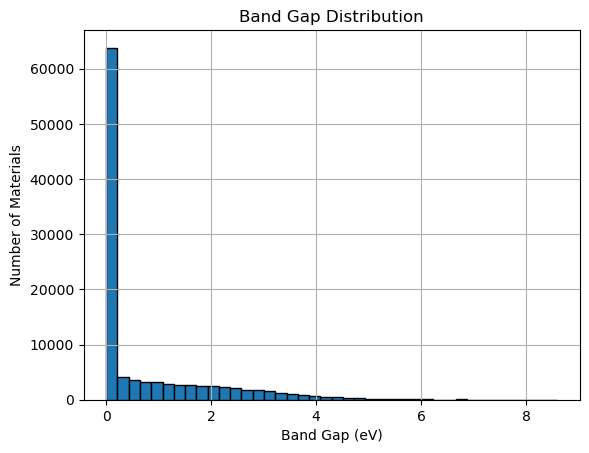

In [3]:
#Band Gap Distribution across all materials
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")


df["band_gap"].hist(bins=40, edgecolor='black')
plt.xlabel("Band Gap (eV)")
plt.ylabel("Number of Materials")
plt.title("Band Gap Distribution")
plt.show()

C:\Users\AhmedFahmy\AppData\Local\Temp\ipykernel_7276\1072677899.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


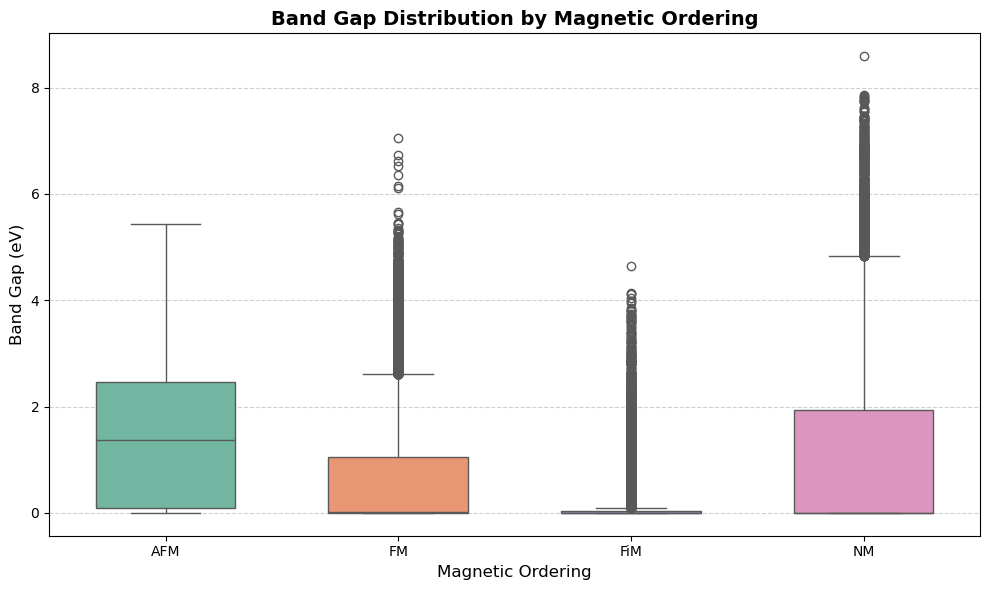

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Sorted order of classes by median band gap (optional)
order = df.groupby("ordering")["band_gap"].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x="ordering",
    y="band_gap",
    order=order,
    palette="Set2",              # Soft color palette
    showfliers=True,            # Hide outliers to reduce clutter
    width=0.6                    # Make boxes narrower for clarity
)

# Titles and labels
plt.title("Band Gap Distribution by Magnetic Ordering", fontsize=14, weight='bold')
plt.xlabel("Magnetic Ordering", fontsize=12)
plt.ylabel("Band Gap (eV)", fontsize=12)

# Optional: add grid
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


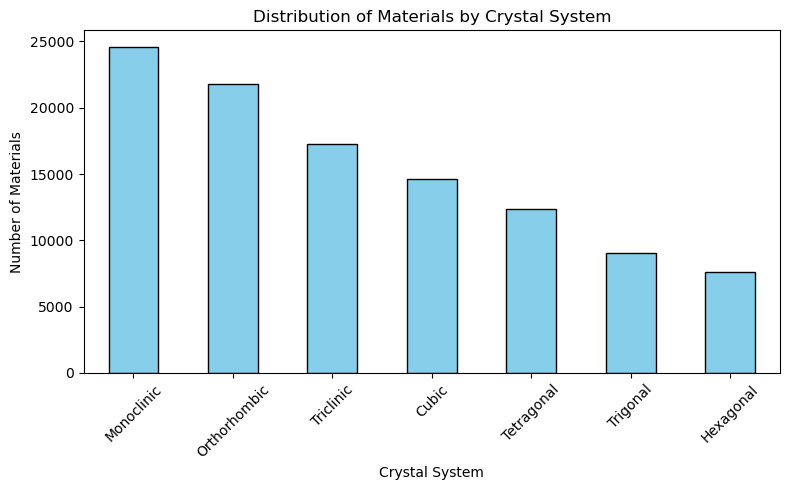

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re



# Correct crystal system parser
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

# Apply extraction
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# Count and plot
counts = df["crystal_system"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Materials by Crystal System")
plt.xlabel("Crystal System")
plt.ylabel("Number of Materials")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 400}

Classification Report:
              precision    recall  f1-score   support

         AFM       0.62      0.22      0.32       684
          FM       0.80      0.93      0.86      7207
         FiM       0.65      0.30      0.41      1027
          NM       0.94      0.90      0.92      5134

    accuracy                           0.84     14052
   macro avg       0.75      0.59      0.63     14052
weighted avg       0.83      0.84      0.82     14052



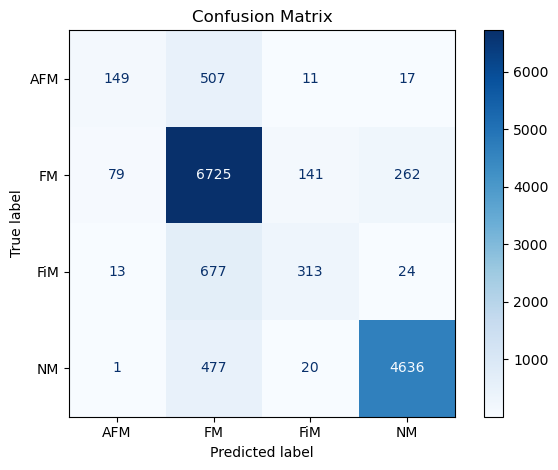

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# === 2. Parse elements column: ['Element Fe', 'Element O'] → ['Fe', 'O'] ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm","energy_above_hull", "band_gap", "density_atomic", "numberofelements","volume","nsites","density","efermi","formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Stratified Train/Test Split ===
if df.shape[0] > 0 and len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    # === 10. GridSearchCV to find best Random Forest parameters ===
    param_grid = {
        'n_estimators': [400],
        'max_depth': [50],
        'class_weight': ['balanced'],       
        'min_samples_split': [5],
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring='f1_weighted',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

    # === 11. Predict and Report ===
    y_pred = best_clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # === 12. Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data or diversity in target classes to perform training.")



🔍 Top 20 Most Important Features:
                      Feature  Importance
3                    band_gap    0.119918
4              density_atomic    0.072336
2           energy_above_hull    0.071363
10  formation_energy_per_atom    0.069983
0                         cbm    0.065913
6                      volume    0.057450
8                     density    0.054637
1                         vbm    0.053858
9                      efermi    0.049124
7                      nsites    0.048541
53                         Mn    0.025245
35                         Fe    0.024462
62                          O    0.020749
5            numberofelements    0.019374
50                         Li    0.017920
27                         Co    0.015615
28                         Cr    0.013504
93                          V    0.010516
60                         Ni    0.010445
37                         Gd    0.008208


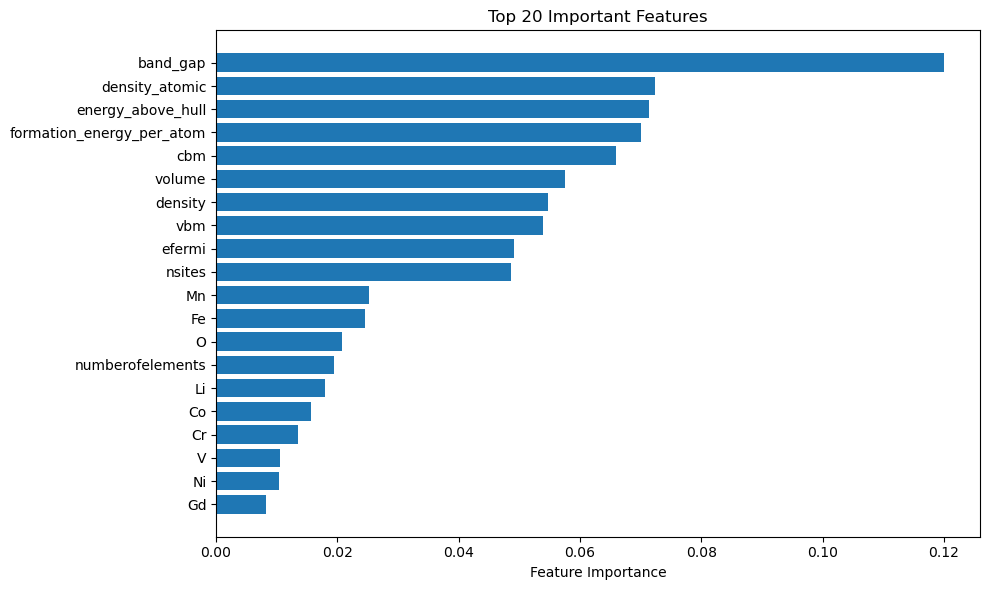

In [9]:
# === 13. Feature Importance Plot ===
importances = best_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20
top_n = 20
print("\n🔍 Top {} Most Important Features:".format(top_n))
print(feat_importances.head(top_n))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'].head(top_n)[::-1], 
         feat_importances['Importance'].head(top_n)[::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features")
plt.tight_layout()
plt.show()


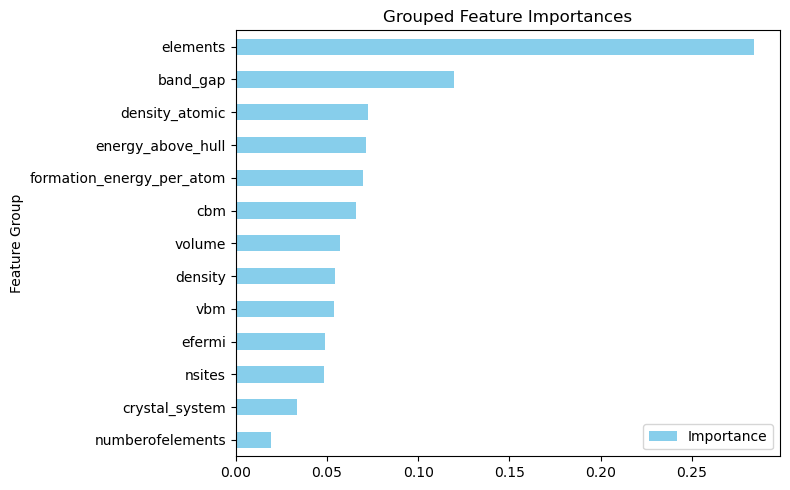

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances from the best model (after GridSearch)
importances = best_clf.feature_importances_
feature_names = X.columns

#"cbm", "vbm","energy_above_hull", "band_gap", "density_atomic", "numberofelements","volume","nsites","density","efermi","formation_energy_per_atom"

# Grouping
grouped_importance = {
    'cbm':0,
    'vbm': 0,
    'energy_above_hull': 0,
    'formation_energy_per_atom': 0,
    'band_gap': 0,
    'density_atomic': 0,
    'volume': 0,
    'efermi': 0,
    'density': 0,
    'nsites': 0,
    'numberofelements': 0,
    'elements': 0,
    'crystal_system': 0
}

for name, imp in zip(feature_names, importances):
    if name in grouped_importance:
        grouped_importance[name] += imp
    elif name in mlb.classes_:  # element one-hot
        grouped_importance["elements"] += imp
    elif name.startswith("crysys_"):
        grouped_importance["crystal_system"] += imp

# Plot
group_df = pd.DataFrame(list(grouped_importance.items()), columns=["Feature Group", "Importance"])
group_df.sort_values("Importance", ascending=True).plot.barh(x="Feature Group", y="Importance", figsize=(8,5), color="skyblue")
plt.title("Grouped Feature Importances")
plt.tight_layout()
plt.show()


Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 40, 'min_samples_split': 5, 'n_estimators': 250}

Cross-validation scores: [0.82328037 0.82021644 0.82177907 0.82066673]
Mean CV score: 0.8214856521280682
Classification Report (Hold-Out Set):
              precision    recall  f1-score   support

         AFM       0.63      0.22      0.32       547
          FM       0.80      0.93      0.86      5766
         FiM       0.64      0.31      0.42       822
          NM       0.94      0.91      0.92      4107

    accuracy                           0.84     11242
   macro avg       0.75      0.59      0.63     11242
weighted avg       0.83      0.84      0.83     11242



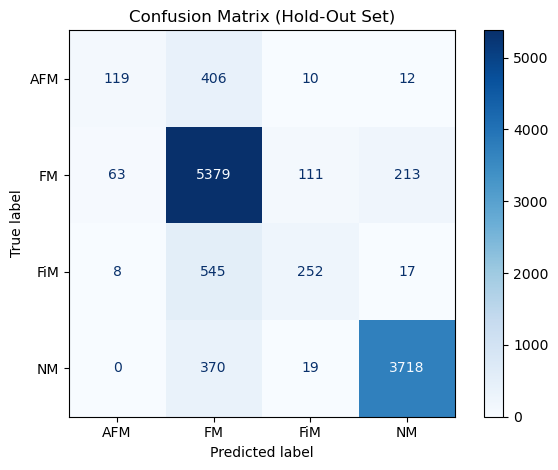

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# === 2. Parse elements column: ['Element Fe', 'Element O'] → ['Fe', 'O'] ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic", "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split into training (80%) and hold-out testing (20%) ===
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. 4-Fold Cross-validation on the 80% training set ===
if X_train.shape[0] > 0 and len(np.unique(y_train)) > 1:
    # Setup StratifiedKFold for 4-fold cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # === 11. GridSearchCV to find best Random Forest parameters ===
    param_grid = {
        'n_estimators': [250],  # Test different values for n_estimators
        'max_depth': [40],    # Limit the depth of trees
        'min_samples_split': [5], # Increase min samples for splitting
        'class_weight': ['balanced', None]  # Conservative class weight
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring='f1_weighted',
        cv=skf,  # Use StratifiedKFold for cross-validation
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV to the training set
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

    # === 12. Evaluate cross-validation results ===
    cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean()}")

    # === 13. Evaluate on the hold-out test set ===
    y_pred_holdout = best_clf.predict(X_holdout)
    print("Classification Report (Hold-Out Set):")
    print(classification_report(y_holdout, y_pred_holdout, target_names=le.classes_))

    # === 14. Confusion Matrix (Hold-Out Set) ===
    cm_holdout = confusion_matrix(y_holdout, y_pred_holdout)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_holdout, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Hold-Out Set)")
    plt.tight_layout()
    plt.show()

else:
    print("❗ Not enough data or diversity in target classes to perform training.")


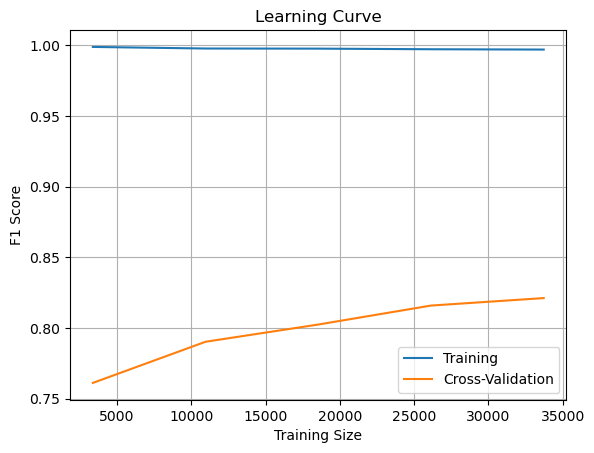

In [3]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X_train, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation')
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()



🔍 Top 20 Most Important Features:
                      Feature  Importance
3                    band_gap    0.105898
10  formation_energy_per_atom    0.077491
4              density_atomic    0.077026
2           energy_above_hull    0.069080
0                         cbm    0.061180
8                     density    0.060055
6                      volume    0.059589
1                         vbm    0.056270
9                      efermi    0.050869
7                      nsites    0.050538
34                         Fe    0.022429
50                         Mn    0.022066
58                          O    0.020077
5            numberofelements    0.018780
47                         Li    0.016406
26                         Co    0.013364
27                         Cr    0.011832
36                         Gd    0.009987
89                          V    0.008763
56                         Ni    0.008234


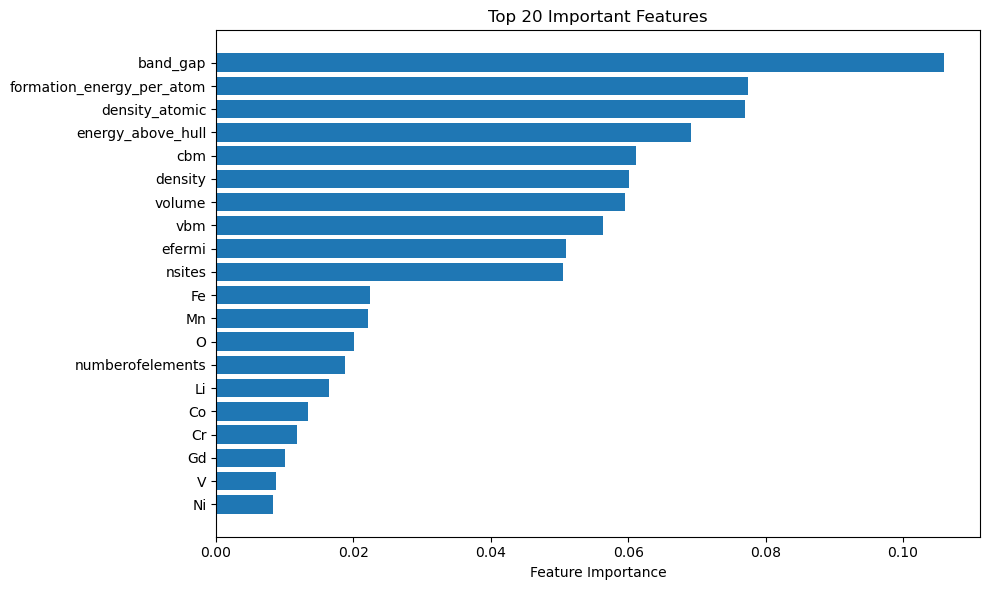

In [12]:
# === 13. Feature Importance Plot ===
importances = best_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20
top_n = 20
print("\n🔍 Top {} Most Important Features:".format(top_n))
print(feat_importances.head(top_n))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'].head(top_n)[::-1], 
         feat_importances['Importance'].head(top_n)[::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features")
plt.tight_layout()
plt.show()


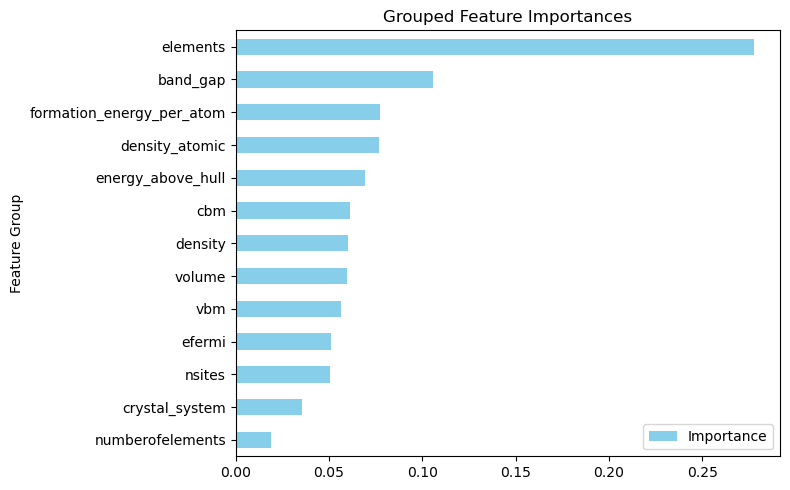

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances from the best model (after GridSearch)
importances = best_clf.feature_importances_
feature_names = X.columns

#"cbm", "vbm","energy_above_hull", "band_gap", "density_atomic", "numberofelements","volume","nsites","density","efermi","formation_energy_per_atom"

# Grouping
grouped_importance = {
    'cbm':0,
    'vbm': 0,
    'energy_above_hull': 0,
    'formation_energy_per_atom': 0,
    'band_gap': 0,
    'density_atomic': 0,
    'volume': 0,
    'efermi': 0,
    'density': 0,
    'nsites': 0,
    'numberofelements': 0,
    'elements': 0,
    'crystal_system': 0
}

for name, imp in zip(feature_names, importances):
    if name in grouped_importance:
        grouped_importance[name] += imp
    elif name in mlb.classes_:  # element one-hot
        grouped_importance["elements"] += imp
    elif name.startswith("crysys_"):
        grouped_importance["crystal_system"] += imp

# Plot
group_df = pd.DataFrame(list(grouped_importance.items()), columns=["Feature Group", "Importance"])
group_df.sort_values("Importance", ascending=True).plot.barh(x="Feature Group", y="Importance", figsize=(8,5), color="skyblue")
plt.title("Grouped Feature Importances")
plt.tight_layout()
plt.show()


In [11]:
#ROC AUC socre

In [ ]:
#SMOTE (Synthetic Minority Over-sampling Technique) 

Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 50, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}

Cross-validation scores: [0.82371204 0.81674822 0.81668029 0.82022016]
Mean CV score: 0.8193401755433357
Classification Report (Hold-Out Set):
              precision    recall  f1-score   support

         AFM       0.46      0.40      0.43       547
          FM       0.84      0.86      0.85      5766
         FiM       0.47      0.46      0.46       822
          NM       0.93      0.91      0.92      4107

    accuracy                           0.83     11242
   macro avg       0.67      0.66      0.66     11242
weighted avg       0.82      0.83      0.82     11242



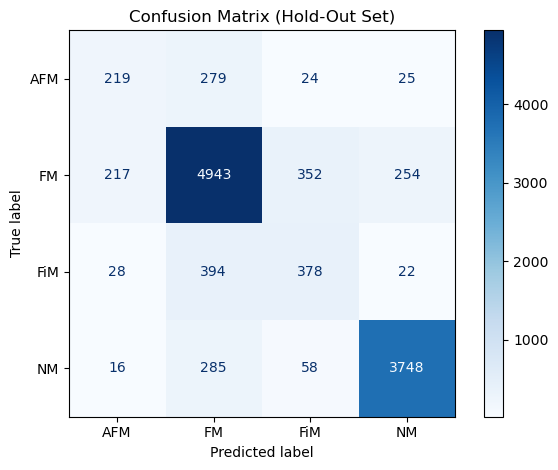

In [1]:
#Trying SMOTENC


import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# === 2. Parse elements column ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop missing values ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic", "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Identify categorical feature indices for SMOTENC ===
# These are indices of the one-hot encoded columns (elements + crystal system)
categorical_feature_indices = list(range(len(numerical_features), X.shape[1]))

# === 10. Train/test split ===
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 11. Set up SMOTENC + RF pipeline ===
smote = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('smote', smote),
    ('rf', rf)
])

# === 12. GridSearchCV ===
param_grid = {
    'rf__n_estimators': [200],
    'rf__max_depth': [50],
    'rf__min_samples_split': [5],
    'rf__class_weight': ['balanced', None]
}

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_weighted',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_

print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores (after SMOTENC) ===
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=skf, scoring='f1_weighted', n_jobs=-1)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

# === 14. Evaluate on hold-out set ===
y_pred_holdout = best_pipeline.predict(X_holdout)
print("Classification Report (Hold-Out Set):")
print(classification_report(y_holdout, y_pred_holdout, target_names=le.classes_))

cm_holdout = confusion_matrix(y_holdout, y_pred_holdout)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_holdout, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Hold-Out Set)")
plt.tight_layout()
plt.show()
